<a href="https://colab.research.google.com/github/dnrghks5583/Way-that-set-threshold-for-setting-PMD/blob/main/CIFAR_100_resnet32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import numpy as np
import os
import math
import tensorflow as tf

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 100
num_classes = 100
data_augmentation = True

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 5

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1
path = '/content/gdrive/My Drive/caltech101_pickle'
image_size = (32, 32)
input_shape = (32, 32, 3)
num_classes = 100

In [49]:
# load the CIFAR100 data
from tensorflow.keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [50]:
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('Model_Type : ' , model_type)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Model_Type :  ResNet32v1
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [52]:
model_path = '/content/gdrive/My Drive/cifar100/CIFAR-100_ResNet32v1_model.140.h5'
model = tf.keras.models.load_model(model_path) # load model

In [53]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 32, 32, 16)   64          conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 32, 32, 16)   0           batch_normalization_31[0][0]     
____________________________________________________________________________________________

In [54]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

313/313 [==============================] - 6s 15ms/step - loss: 1.6230 - acc: 0.6938


[1.6230385303497314, 0.6937999725341797]

In [55]:
print(y_pred)

[[1.6873372e-11 4.6907572e-10 9.4912417e-07 ... 7.3228806e-10
  2.5758161e-05 3.9455485e-06]
 [2.0047843e-09 3.8023682e-08 2.2776414e-06 ... 2.1872845e-06
  3.3003424e-08 8.6025850e-08]
 [6.0400903e-13 8.0730125e-09 6.6040911e-06 ... 9.8298615e-06
  9.6471782e-09 8.7092566e-08]
 ...
 [1.1138513e-08 5.9365338e-08 1.0420982e-08 ... 5.3706273e-10
  7.7770917e-13 5.4920588e-09]
 [3.9473490e-11 2.2270360e-08 3.4664106e-07 ... 5.0199935e-05
  6.9479512e-08 1.8555725e-03]
 [4.1579593e-08 2.1828910e-07 5.3114821e-08 ... 1.0108385e-13
  2.1213463e-08 1.3124741e-08]]


In [56]:
print(sum(y_pred[50]))

0.99999993477369


In [57]:
import tensorflow

cce = tensorflow.keras.losses.categorical_crossentropy(
    y_test,
    y_pred,
    from_logits = False,
    label_smoothing = 0)
cce = cce.numpy()
print(cce)

[1.1901825e+01 7.6566050e-03 3.1896465e+00 ... 1.5436398e-03 2.9797355e-02
 5.6469436e-03]


In [58]:
def classification_Cce(cce, y_test, y_pred) :
  c = []
  m = []
  c_i = []

  for i in range(len(y_test)) :
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]) :
      c.append(cce[i])
      c_i.append(i)
    else :
      m.append(cce[i])

  return c, m, c_i

In [59]:
collect_Cce, missclassification_Cce, collect_Idx = classification_Cce(cce, y_test, y_pred)
print(len(collect_Cce))
print(len(missclassification_Cce))

6938
3062


In [60]:
import matplotlib.pyplot as plt

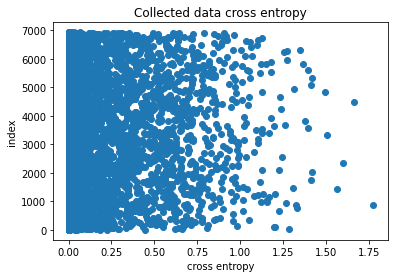

In [61]:
x_value = []
for i in range(len(collect_Cce)) :
  x_value.append(i)

plt.scatter(collect_Cce, x_value)
plt.title('Collected data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

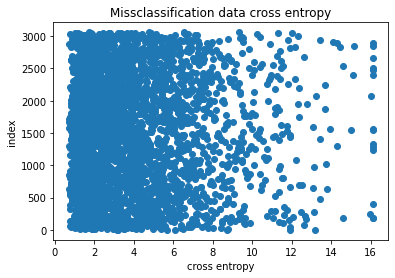

In [62]:
X_value = []
for i in range(len(missclassification_Cce)) :
  X_value.append(i)

plt.scatter(missclassification_Cce, X_value)
plt.title('Missclassification data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

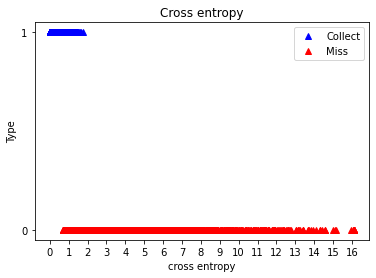

In [63]:
Y = []
for i in range(len(collect_Cce)) :
  Y.append(1)
y = []
for i in range(len(missclassification_Cce)) :
  y.append(0)

values = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12 ,13, 14, 15, 16]

plt.plot(collect_Cce, Y, 'b^', missclassification_Cce, y, 'r^')
plt.title('Cross entropy')
plt.ylabel('Type')
plt.xlabel('cross entropy')
plt.legend(['Collect', 'Miss'])
plt.yticks([1,0])
plt.xticks(values)

plt.show()

In [64]:
print(max(collect_Cce))
print(min(missclassification_Cce))

1.7747233
0.70165634


In [65]:
cnt = 0

for i in collect_Cce : 
  if i < 0.0001 :
    cnt = cnt + 1
print(cnt)
print(cnt/len(collect_Cce))

1255
0.1808878639377342


In [66]:
def static_Threshold() :
  threshold = [0.0000001, 0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
  return threshold

In [67]:
staticThreshold = static_Threshold()
print(staticThreshold)

[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


In [68]:
n_cce = cce/max(cce)

In [69]:
def dynamic_Threshold(cce) :
  #Z = [1.96, 2.17, 2.576] # 95%, 97%, 99% two-tails
  Z = [2.326, 1.96, 1.645] # 95%, 97.5%, 99% one-tails
  threshold = []
  x_ = np.mean(cce)
  o = np.std(cce)
  n = len(cce) **(1/2)
  print(x_)
  print(o)
  print(n)
  for z in Z :
    threshold.append(x_- (z * o)/n)

  return threshold

In [70]:
dynamicThreshold = dynamic_Threshold(n_cce)
dynamicThreshold.append(min(missclassification_Cce))
print(dynamicThreshold)

0.081324235
0.14722003
100.0
[0.07789989669710398, 0.07843872200846672, 0.0789024651043117, 0.70165634]


In [71]:
def detection(threshold, cce, collect) : 
  PMD = []
  for i in collect :
    if cce[i] > threshold :
        PMD.append(i)
  return PMD

In [72]:
def detection_PMD(list_of_threshold, cce, collect):
  PMD_by_threshold = []

  for th in list_of_threshold :
    PMD_by_threshold.append(detection(th, cce, collect))
  return PMD_by_threshold

In [73]:
PMD_By_Static_Threshold  = detection_PMD(staticThreshold, cce, collect_Idx)
PMD_By_Dynamic_Threshold = detection_PMD(dynamicThreshold, cce, collect_Idx)

In [74]:
for i in range(len(PMD_By_Static_Threshold)) :
  print(staticThreshold[i], len(PMD_By_Static_Threshold[i]))

for i in range(len(PMD_By_Dynamic_Threshold)) :
  print(dynamicThreshold[i], len(PMD_By_Dynamic_Threshold[i]))

1e-07 6938
1e-06 6623
1e-05 6282
5e-05 5892
0.0001 5683
0.0005 5077
0.001 4760
0.01 3570
0.05 2495
0.1 1971
0.2 1420
0.3 1074
0.4 818
0.5 624
0.07789989669710398 2162
0.07843872200846672 2160
0.0789024651043117 2152
0.70165634 301


In [75]:
import cv2

In [76]:
def rotate_img_set(data_set, angle) : # 10' ~ 90'
  rotated_img = []
  print("rotate " + str(angle) + "degree")
  for img in data_set :
    m = cv2.getRotationMatrix2D((16, 16), angle, 1)
    new_img = cv2.warpAffine(img, m, (32, 32), cv2.INTER_AREA, borderMode = 1)
    rotated_img.append(new_img)
    
  return rotated_img

In [77]:
def img_trim(img, size) :
  w = 32
  h = 32
  new_img = img[size:size+h, size:size+w]
  return new_img

In [78]:
def size_Adjust(x_test, rate) :

  new_data_set = []
  if rate > 1 : # aggmentation
    print("augmentation " + str(rate) + "%")
    size = round(32*rate/2 - 16)
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_LINEAR)
      new_img = img_trim(new_img, size)
      new_data_set.append(new_img)
  else :  # reduction
    print("reduction " + str(rate) + "%")
    size = round(32 * (1-rate))
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_AREA)
      new_img = np.pad(new_img, ((size, size), (size, size), (0, 0)), mode = 'edge')
      new_img = cv2.resize(new_img, (32, 32), interpolation = cv2.INTER_AREA)
      new_data_set.append(new_img)

  return new_data_set

In [79]:
def get_MD(y_pred, new_y_pred, y_test) :
  MD = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) and np.argmax(new_y_pred[i]) != np.argmax(y_test[i]) :
      MD.append(i)
  print("    Find MD : " + str(len(MD)))
  return MD

In [80]:
def calc_Acc(new_y_pred, y_test) :
  cnt = 0
  for i in range(len(y_pred)) :
    if np.argmax(new_y_pred[i]) == np.argmax(y_test[i]) :
      cnt = cnt + 1
  acc = cnt/len(y_pred)
  print("  Acc : " + str(acc))

In [81]:
def get_PMD_Precision(MD, PMD) :
  cnt = 0
  if len(PMD) == 0 :
    return 0
  print("        PMD : " + str(len(PMD)))
  print("        MD : " + str(len(MD)))
  for data in PMD : 
    if data in MD :
      cnt = cnt + 1
  precision = cnt/len(PMD)
  print("        Precision : " + str(precision))
  return precision

In [82]:
def get_PMD_Recall(MD, PMD) :
  cnt = 0
  if len(MD) == 0 :
    return 0
  for data in MD : 
    if data in PMD :
      cnt = cnt + 1
  recall = cnt/len(MD)
  print("        Recall : " + str(recall))
  return recall

In [83]:
def get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test) : #
  Stp = []   # [ th = 0.1_pre1, th = 0.2_pre2, ... , th = 0.9_pre9 ] number of elements = 9
  Dtp = []   # [ th = min_pre1, th = 95%_pre2, ... , th = 99%_pre4 ] number of elements = 4
  Str = []   # [ th = 0.1_rec1, th = 0.2_rec2, ... , th = 0.9_rec9 ] number of elements = 9
  Dtr = []   # [ th = min_rec1, th = 95%_rec2, ... , th = 99%_rec4 ] number of elements = 4
  st = 1
  dt = 1

  new_y_pred = model.predict(data_set)
  calc_Acc(new_y_pred, y_test)
  MD = get_MD(y_pred, new_y_pred, y_test)

  print("      " + "static threshold")
  for s in PMD_By_Static_Threshold :
    print("        " + str(st) + "st static threshold")
    st = st + 1
    Stp.append(get_PMD_Precision(MD, s))
    Str.append(get_PMD_Recall(MD, s))
    print()

  print("      " + "dynamic threshold")
  for d in PMD_By_Dynamic_Threshold :
    print("        " + str(dt) + "st dynamic threshold")
    dt = dt + 1
    Dtp.append(get_PMD_Precision(MD, d))
    Dtr.append(get_PMD_Recall(MD, d))
    print()

  return Stp, Dtp, Str, Dtr

In [84]:
def get_Avg_Result(lists) : #
  x = len(lists[0]) # static = 9, dynamic = 4
  y = len(lists)    # aggmentation, reduction = 4, rotate = 9
  Avg = []

  for i in range(x) :
    temp = 0
    for j in range(y) :
      temp = temp + lists[j][i]
    Avg.append(temp/y)
  return Avg

In [85]:
def validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rate, rotated = False) : #

  stp_Result = []
  dtp_Result = []
  str_Result = []
  dtr_Result = []

  for rate in list_of_rate :
    if rotated :
      data_set = rotate_img_set(x_test, rate)
    else :
      data_set = size_Adjust(x_test, rate)
    data_set = np.array(data_set)

    Stp, Dtp, Str, Dtr = get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test)
    stp_Result.append(Stp)
    dtp_Result.append(Dtp)
    str_Result.append(Str)
    dtr_Result.append(Dtr)

  stp_Result = get_Avg_Result(stp_Result)
  dtp_Result = get_Avg_Result(dtp_Result)
  str_Result = get_Avg_Result(str_Result)
  dtr_Result = get_Avg_Result(dtr_Result)
  return stp_Result, dtp_Result, str_Result, dtr_Result

In [86]:
def print_Result(stp_Result, dtp_Result, str_Result, dtr_Result, comments, staticThreshold, dynamicThreshold) :
  print(comments)
  print(staticThreshold)
  print(stp_Result)
  print(str_Result)
  print(dynamicThreshold)
  print(dtp_Result)
  print(dtr_Result)

In [87]:
list_of_ag_rate = [1.1, 1.2, 1.3, 1.4]
list_of_rd_rate = [0.9, 0.8, 0.7, 0.6]
list_of_degree = [10, 20, 30, 40, 50, 60 ,70, 80 ,90]

In [88]:
rot_Stp, rot_Dtp, rot_Str, rot_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_degree, True)   ## rotated

rotate 10degree
  Acc : 0.6555
    Find MD : 946
      static threshold
        1st static threshold
        PMD : 6938
        MD : 946
        Precision : 0.13635053329489766
        Recall : 1.0

        2st static threshold
        PMD : 6623
        MD : 946
        Precision : 0.14283557300317076
        Recall : 1.0

        3st static threshold
        PMD : 6282
        MD : 946
        Precision : 0.1504297994269341
        Recall : 0.9989429175475687

        4st static threshold
        PMD : 5892
        MD : 946
        Precision : 0.16004752206381534
        Recall : 0.9968287526427061

        5st static threshold
        PMD : 5683
        MD : 946
        Precision : 0.16558155903572058
        Recall : 0.9947145877378436

        6st static threshold
        PMD : 5077
        MD : 946
        Precision : 0.18199724246602325
        Recall : 0.9767441860465116

        7st static threshold
        PMD : 4760
        MD : 946
        Precision : 0.1915966386554622
   

In [89]:
ag_Stp, ag_Dtp, ag_Str, ag_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_ag_rate, False)    ## augmentation

augmentation 1.1%
  Acc : 0.6756
    Find MD : 839
      static threshold
        1st static threshold
        PMD : 6938
        MD : 839
        Precision : 0.1209282213894494
        Recall : 1.0

        2st static threshold
        PMD : 6623
        MD : 839
        Precision : 0.1266797523780764
        Recall : 1.0

        3st static threshold
        PMD : 6282
        MD : 839
        Precision : 0.13355619229544732
        Recall : 1.0

        4st static threshold
        PMD : 5892
        MD : 839
        Precision : 0.14137813985064493
        Recall : 0.9928486293206198

        5st static threshold
        PMD : 5683
        MD : 839
        Precision : 0.1465775118775295
        Recall : 0.9928486293206198

        6st static threshold
        PMD : 5077
        MD : 839
        Precision : 0.16328540476659445
        Recall : 0.9880810488676997

        7st static threshold
        PMD : 4760
        MD : 839
        Precision : 0.17394957983193277
        Recall : 

In [90]:
rd_Stp, rd_Dtp, rd_Str, rd_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rd_rate, False)   ## reduction

reduction 0.9%
  Acc : 0.6427
    Find MD : 1182
      static threshold
        1st static threshold
        PMD : 6938
        MD : 1182
        Precision : 0.17036609974055925
        Recall : 1.0

        2st static threshold
        PMD : 6623
        MD : 1182
        Precision : 0.17846897176506116
        Recall : 1.0

        3st static threshold
        PMD : 6282
        MD : 1182
        Precision : 0.18783826806749443
        Recall : 0.9983079526226735

        4st static threshold
        PMD : 5892
        MD : 1182
        Precision : 0.19942294636795654
        Recall : 0.994077834179357

        5st static threshold
        PMD : 5683
        MD : 1182
        Precision : 0.20640506774590886
        Recall : 0.9923857868020305

        6st static threshold
        PMD : 5077
        MD : 1182
        Precision : 0.22710261965727793
        Recall : 0.9754653130287648

        7st static threshold
        PMD : 4760
        MD : 1182
        Precision : 0.2394957983193

In [91]:
print_Result(rot_Stp, rot_Dtp, rot_Str, rot_Dtr, "Rotation", staticThreshold, dynamicThreshold)

Rotation
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.5586464238813618, 0.5675172379082993, 0.5755421132689519, 0.5832956174096703, 0.5881478874616303, 0.600354540082726, 0.6072362278244632, 0.6352629940865235, 0.6652415942997105, 0.6803089238401262, 0.7019561815336464, 0.7074280984895511, 0.721407226297202, 0.7359330484330484]
[1.0, 0.9735756655756997, 0.9408841836533104, 0.8995667441212549, 0.8776439980161528, 0.8079989845396031, 0.770501078900575, 0.620389107061094, 0.4659014976423722, 0.38227066816992766, 0.2897142129107217, 0.22479262127202185, 0.17613013173315406, 0.13777497336298486]
[0.07789989669710398, 0.07843872200846672, 0.0789024651043117, 0.70165634]
[0.6759687532120465, 0.6757716049382716, 0.6765799256505577, 0.7648578811369509]
[0.41421429766995405, 0.4137025327350389, 0.4125595950544125, 0.07067970972308327]


In [92]:
print_Result(ag_Stp, ag_Dtp, ag_Str, ag_Dtr, "Augmentation", staticThreshold, dynamicThreshold)

Augmentation
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.23346065148457767, 0.24263928733202475, 0.2529847182425979, 0.26446877121520707, 0.2716434981523843, 0.2917077013984637, 0.30425420168067224, 0.3579131652661064, 0.4097194388777555, 0.43721461187214616, 0.46989436619718306, 0.49860335195530725, 0.5302567237163814, 0.5440705128205128]
[1.0, 0.9946447423986486, 0.9865835075738849, 0.9706933170340661, 0.9636154641239915, 0.9325042389528071, 0.9164278605312893, 0.8244994611634705, 0.6757664510264775, 0.5782556654363872, 0.45480564790644773, 0.36793746347963385, 0.2999152875230895, 0.2371741583525697]
[0.07789989669710398, 0.07843872200846672, 0.0789024651043117, 0.70165634]
[0.4272664199814986, 0.42685185185185187, 0.4282063197026022, 0.6071428571428571]
[0.6161147847815474, 0.614944724167929, 0.6147119327827939, 0.13103896458105974]


In [93]:
print_Result(rd_Stp, rd_Dtp, rd_Str, rd_Dtr, "Reduction", staticThreshold, dynamicThreshold)

Reduction
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.4862712597290285, 0.4976974180884795, 0.5084368035657434, 0.5201968771215206, 0.5278022171388351, 0.5470750443175103, 0.5580357142857143, 0.6025910364145659, 0.6432865731462926, 0.6561390157280568, 0.6765845070422535, 0.6922718808193669, 0.7035452322738386, 0.7151442307692307]
[1.0, 0.9844844954377641, 0.9627246298619295, 0.9340458371727459, 0.9195487491080433, 0.8661067460265495, 0.8365233728035405, 0.7042346894328777, 0.5461308218179942, 0.4472600312972951, 0.3381196737408197, 0.26468650286502904, 0.20715937732676032, 0.16362681318597774]
[0.07789989669710398, 0.07843872200846672, 0.0789024651043117, 0.70165634]
[0.6532146160962072, 0.6532407407407408, 0.6536942379182156, 0.7433554817275747]
[0.48619769326845064, 0.48588666981546935, 0.48449254681524895, 0.08396529190840916]
